## Import library

In [1]:
import os
import glob
import natsort
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, accuracy_score
import copy
import datetime
import json
from ast import literal_eval
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.svm import SVC

## Define functions

In [2]:
def get_Data_activity(dataPath, date, data_collection):

    tmp_datetime = datetime.datetime.strptime(date, '%Y-%m-%d')

    date_list = [tmp_datetime + datetime.timedelta(minutes=tmp) for tmp in range(1440)]
    value_list = [0] * 1440
    if 'time' not in data_collection:
        data_collection['time'] = np.array([])
        data_collection['value'] = np.array([])
    data_collection['time'] = np.append(data_collection['time'], np.array(date_list))
    data_collection['value'] = np.append(data_collection['value'], np.array(value_list))

    with open(dataPath) as f:
        s = f.read()

    if s != '':
        tmp_s = s.replace("'", '"')
        tmpData = json.loads(tmp_s)

        kindOfData = 'activities-heart-intraday'  
        if kindOfData in tmpData:
            for oneMinute_data in tmpData[kindOfData]['dataset']:
                tmp = datetime.datetime.strptime(date + ' ' + oneMinute_data['time'], '%Y-%m-%d %H:%M:%S')
                data_collection['value'][data_collection['time'] == tmp] = oneMinute_data['value']

    return data_collection

def get_Data_sleep(dataPath, data_collection):

    with open(dataPath) as f:
        s = f.read()

    tmp_s = s.replace("'", '"')
    tmp_s = tmp_s.replace('True', '"True"')
    tmp_s = tmp_s.replace('False', '"False"')
    tmpData = json.loads(tmp_s)

    if tmpData['sleep'] != []:
        for ii in range(len(tmpData['sleep'])):
            for sleep_data in tmpData['sleep'][ii]['levels']['data']:
                duration_minutes = sleep_data['seconds'] // 60
                start_datetime = datetime.datetime.strptime(sleep_data['dateTime'].split('.000')[0], '%Y-%m-%dT%H:%M:%S')

                for minute in range(duration_minutes):
                    tmp_datetime = start_datetime + datetime.timedelta(minutes=minute)
                    hour_min = datetime.datetime(tmp_datetime.year, tmp_datetime.month, tmp_datetime.day, tmp_datetime.hour, tmp_datetime.minute)

                    data_collection['sleep'][data_collection['time'] == hour_min] = int(1)

    return data_collection


def get_sleep_hr(data_collection, sleep=True, all=False):
    time = data_collection['time']
    hr_value = data_collection['value']
    sleep_flg = data_collection['sleep']
    
    df = pd.DataFrame(np.array([time, hr_value, sleep_flg]).T, columns=["time", "hr_value", "sleep_flg"])
    
    if not all:
        if sleep:
            df = df[df["sleep_flg"]==1]
        else:
            df = df[df["sleep_flg"]==0]
    
    return df

def get_sleep_hr_data(hr_data_paths, sleep_data_paths):

    data_collection = dict()
    for hr_data_path in hr_data_paths:
        date = os.path.basename(hr_data_path).split('.txt')[0]
        data_collection = get_Data_activity(hr_data_path, date, data_collection)
    
    start_datetime = datetime.datetime.strptime(os.path.basename(sleep_data_paths[0]).split('.txt')[0], '%Y-%m-%d')
    end_datetime = datetime.datetime.strptime(os.path.basename(sleep_data_paths[-1]).split('.txt')[0], '%Y-%m-%d') + datetime.timedelta(days=1)
    data_collection['sleep'] = np.array([0] * 1440 * (end_datetime - start_datetime).days)

    sleep_start_end_datetime = dict()
    for sleep_data_path in sleep_data_paths:
        try:
            data_collection = get_Data_sleep(sleep_data_path, data_collection)
            date = datetime.datetime.strptime(os.path.basename(sleep_data_path).split('.txt')[0], '%Y-%m-%d')
            with open(sleep_data_path) as file:
                data_text = file.read()
            tmp_s = data_text.replace("'", '"')
            tmp_s = tmp_s.replace('true', '"True"')
            tmp_s = tmp_s.replace('false', '"False"')
            data_dict = json.loads(tmp_s)
            start_time = data_dict['sleep'][0]['startTime'].split('.')[0]
            end_time = data_dict['sleep'][0]['endTime'].split('.')[0]
            start_datetime = datetime.datetime.strptime(start_time, '%Y-%m-%dT%H:%M:%S')
            end_datetime = datetime.datetime.strptime(end_time, '%Y-%m-%dT%H:%M:%S')

            sleep_start_end_datetime[date] = {'start':start_datetime, 'end':end_datetime}
        except:
            pass
    df = pd.DataFrame()
    df['time'] = data_collection['time']
    df['hr_value'] = data_collection['value']
    df['sleep_flg'] = data_collection['sleep']

    return df, sleep_start_end_datetime

def get_RHR(hr_data_paths):
    date_list = []
    rhr_list = []

    for hr_data_path in hr_data_paths:
        #Get date
        date = datetime.datetime.strptime(os.path.basename(hr_data_path).split('.txt')[0], '%Y-%m-%d')
        #Get RHR value
        with open(hr_data_path) as file:
            hr_data_text = file.read()
        try:
            hr_data_dict = literal_eval(hr_data_text)
            rhr_value = hr_data_dict['activities-heart'][0]['value']['restingHeartRate']
            rhr_list.append(rhr_value)
            date_list.append(date)
        except:
            pass
    #Create RHR data frame and output the data frame as csv
    df_rhr = pd.DataFrame()
    df_rhr['Date'] = date_list
    df_rhr['Date'] = pd.to_datetime(df_rhr['Date'])
    df_rhr['RHR'] = rhr_list

    return df_rhr


def get_min_sleep_hr(sleep_time, df_hr, df_analysis_data):

    # 取得されたデータの睡眠時心拍の抽出
    tmp_df_sleep_hr = df_hr[df_hr['sleep_flg']==1]# df_hrを用いて睡眠中の心拍数を抽出
    tmp_df_sleep_hr.drop(index=tmp_df_sleep_hr[tmp_df_sleep_hr['hr_value']==0].index, inplace=True)

    # 1日ごとの睡眠時心拍の抽出し、1日ごｔの睡眠時心拍の最小値を導出
    tmp_dict = dict()
    for date in sleep_time:
        start = sleep_time[date]['start']
        end = sleep_time[date]['end']
        sleep_hr = tmp_df_sleep_hr.loc[start:end, 'hr_value'].values
        min_sleep_hr = np.min(sleep_hr)
        tmp_dict[date] = min_sleep_hr

    df_analysis_data['min_sleep_hr'] = [0] * len(df_analysis_data.index.tolist())
    for date in tmp_dict:
        df_analysis_data.loc[date, 'min_sleep_hr'] = tmp_dict[date]

    return df_analysis_data



## データセット構築・解析のための準備

In [3]:
save_path ='analysis_results'
if not os.path.exists(save_path):
    os.makedirs(save_path)


# 使用するデータのパスなどの設定
file_path = 'analysis_data'
fitbit_path = glob.glob(os.path.join(file_path, 'activities', '*'))
hr_path = os.path.join(fitbit_path[0], 'hr')
sleep_path = os.path.join(fitbit_path[0], 'sleep')
# データファイルのパスを取得
hr_data_paths = natsort.natsorted(glob.glob(os.path.join(hr_path, '*.txt')))
sleep_data_paths = natsort.natsorted(glob.glob(os.path.join(sleep_path, '*.txt')))

# 生データの読み込み
df_analysis_data = get_RHR(hr_data_paths=hr_data_paths)
df_hr, sleep_time = get_sleep_hr_data(hr_data_paths, sleep_data_paths)
df_hr['time'] = pd.to_datetime(df_hr['time'])
df_hr = df_hr.reset_index(drop=True)
df_hr = df_hr.set_index('time')
df_analysis_data = df_analysis_data.set_index('Date')
df_analysis_data.head()

,RHR
Date,
2022-06-05,65
2022-06-06,67
2022-06-07,69
2022-06-08,66
2022-06-09,65


## データセット構築

In [4]:
df_analysis_data = get_min_sleep_hr(sleep_time, df_hr, df_analysis_data)
df_analysis_data.head()

/home/neuro/.local/lib/python3.6/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,RHR,min_sleep_hr
Date,,
2022-06-05,65,55.0
2022-06-06,67,57.0
2022-06-07,69,65.0
2022-06-08,66,69.0
2022-06-09,65,54.0


## SVM classification

In [5]:
#========================================
# Conducting support vector machine
#========================================
def SVM(input_data, target_data):
    X_train, X_test, y_train, y_test = train_test_split(input_data, target_data, test_size=0.2, shuffle=True, random_state=0, stratify=target_data)

    param_list = [0.001,0.01,0.1,1,10,100]
    best_acc = 0
    best_gamma = 0
    best_C = 0
    y_best = []

    for gamma in param_list:
        for C in param_list:
            clf = SVC(kernel='linear', gamma=gamma, C=C)
            clf.fit(X_train, y_train)
            y_test_pred = clf.predict(X_test)
            test_acc = accuracy_score(y_test, y_test_pred)
            
            if test_acc > best_acc:
                best_acc = test_acc
                best_gamma = gamma
                best_C = C
                y_best = y_test_pred
    return best_acc, best_gamma, best_C, y_best, y_test

def SVM_for_estimation_of_condition(df_analysis_data, save_path):

    input_data = df_analysis_data[['min_sleep_hr']].values
    target_data = df_analysis_data['RHR'].values

    threshold = np.median(target_data)
    target_data[target_data < threshold] = 0
    target_data[target_data >= threshold] = 1

    best_score, best_gamma, best_C, y_pred, y_test = SVM(input_data, target_data.reshape(-1, 1))
    print('best: {}, best gamma: {}, best_C: {}'.format(best_score, best_gamma, best_C))

    tp, fn, fp, tn = confusion_matrix(y_test.reshape(-1, 1), y_pred).reshape(-1)
    df_cmx = pd.DataFrame([[tp, fn], [fp, tn]], index=['Actual Positive', 'Actual Negative'], columns=['Predicted Positive', 'Predicted Negative'])
    plt.figure(figsize = (10,7))
    sns.set(font_scale=1.8)
    sns.heatmap(df_cmx, annot=True)
    plt.tight_layout()
    plt.savefig(os.path.join(save_path, 'test_confusion_matrix.png'))

    Sensitivity = tp / (tp + fn)
    Specificity = tn / (fp + tn)
    BACC = (Sensitivity + Specificity) / 2
    print('BACC: {}, Sensitivity: {}, Specificity: {}'.format(BACC, Sensitivity, Specificity))

/home/neuro/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/neuro/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/neuro/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/neuro/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for

best: 0.7142857142857143, best gamma: 0.001, best_C: 0.001
BACC: 0.5, Sensitivity: 0.0, Specificity: 1.0


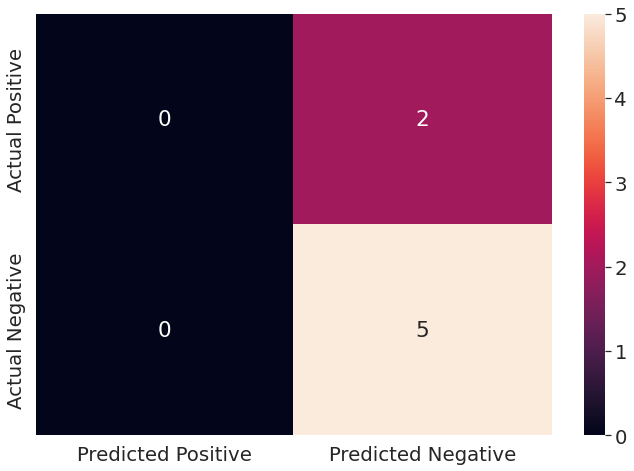

In [6]:
# SVMの実行
SVM_for_estimation_of_condition(df_analysis_data, save_path)